In [1]:
# Generic ones
import numpy as np
import pandas as pd
import os

# Word processing libraries
import re
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# Widen the size of each cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import glob
import gzip

# dfs=[]
data = None
total_count=0
keywords_str='#chinavirus|#wuhanvirus|#chopstickflu|#kungfuvirus|#chinesevirus|#kungflu'
print('filtering by:', keywords_str)

for file in glob.glob("E:\\Projects\\twitter_covid\\2020-03\\*.gz"):
#     print(file)
    df = pd.read_json(path_or_buf=file, lines=True, compression='infer')
#     print('Read. Size: ', df.shape)
    
    total_count+=df.shape[0]
    df = df[df['full_text'].str.contains("(?i)"+keywords_str)]
    df.reset_index(inplace = True, drop = True)
    if data is None:
        data = df
    else:
        data = pd.concat([data, df], axis = 0)
        # Reset_index
        data.reset_index(inplace = True, drop = True)
        
data_orig=data.copy()

print('Size of dataset before filtering:', total_count)
print('Size of dataset after filtering:', data.shape[0])



filtering by: #chinavirus|#wuhanvirus|#chopstickflu|#kungfuvirus|#chinesevirus|#kungflu
Size of dataset before filtering: 2962836
Size of dataset after filtering: 4390


In [3]:
data['hashtags'] = data['entities'].apply(lambda x: x['hashtags'])
data['hashtags'].head(3)

0    [{'text': 'coronavirus', 'indices': [88, 100]}...
1    [{'text': 'coronavirus', 'indices': [58, 70]},...
2           [{'text': 'KUNGFLU', 'indices': [27, 35]}]
Name: hashtags, dtype: object

In [4]:
# Remove empty tweets
data.dropna(subset = ['full_text'], inplace = True)
# The unicode accounts for Chinese characters and punctuations.
def strip_chinese_words(string):
    # list of english words
    en_list = re.findall(u'[^\u4E00-\u9FA5\u3000-\u303F]', str(string))
    
    # Remove word from the list, if not english
    for c in string:
        if c not in en_list:
            string = string.replace(c, '')
    return string
# Apply strip_chinese_words(...) on the column 'text'
data['full_text'] = data['full_text'].apply(lambda x: strip_chinese_words(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,withheld_in_countries,withheld_scope,withheld_copyright,hashtags
0,2020-03-02 09:07:09+00:00,1234404869731213312,1234404869731213312,RT @CellosSuits: European Union\n\n- Nike temp...,False,"[0, 140]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://twitter.com/FreeBet13"" rel=""n...",NaN,...,0,False,False,NaN,en,{'created_at': 'Mon Mar 02 08:57:46 +0000 2020...,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [88, 100]}..."
1,2020-03-02 09:07:34+00:00,1234404974756421632,1234404974756421632,Britain\n\n- Health worker at cancer centre am...,False,"[0, 278]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,0.0,en,NaN,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [58, 70]},..."
2,2020-03-02 09:08:40+00:00,1234405249454002176,1234405249454002176,So if China eradicates the #KUNGFLU and then c...,False,"[0, 110]","{'hashtags': [{'text': 'KUNGFLU', 'indices': [...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,NaN,en,NaN,NaN,NaN,NaN,"[{'text': 'KUNGFLU', 'indices': [27, 35]}]"
3,2020-03-02 09:33:21+00:00,1234411461348405254,1234411461348405248,RT @PSCAsafecities: گھبرائیں نہیں بلکہ احتیاط ...,False,"[0, 140]","{'hashtags': [{'text': 'PSCA', 'indices': [52,...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,...,0,False,False,NaN,ur,{'created_at': 'Mon Mar 02 05:47:54 +0000 2020...,NaN,NaN,NaN,"[{'text': 'PSCA', 'indices': [52, 57]}, {'text..."
4,2020-03-02 09:51:37+00:00,1234416057739350016,1234416057739350016,RT @AsiyeUyghur: https://t.co/aoUVTEMCB8\n# #...,False,"[0, 140]","{'hashtags': [{'text': '集中营', 'indices': [41, ...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,0.0,und,{'created_at': 'Mon Mar 02 09:45:03 +0000 2020...,NaN,NaN,NaN,"[{'text': '集中营', 'indices': [41, 45]}, {'text'..."


In [5]:
# Define function to sieve out @users in a tweet:
def mentioned_users(string):
    usernames = re.findall('@[^\s]+', string)
    return usernames
# Create a new column and apply the function on the column 'text'
data['mentioned_users'] = data['full_text'].apply(lambda x: mentioned_users(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,lang,retweeted_status,withheld_in_countries,withheld_scope,withheld_copyright,hashtags,mentioned_users
0,2020-03-02 09:07:09+00:00,1234404869731213312,1234404869731213312,RT @CellosSuits: European Union\n\n- Nike temp...,False,"[0, 140]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://twitter.com/FreeBet13"" rel=""n...",NaN,...,False,False,NaN,en,{'created_at': 'Mon Mar 02 08:57:46 +0000 2020...,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [88, 100]}...",[@CellosSuits:]
1,2020-03-02 09:07:34+00:00,1234404974756421632,1234404974756421632,Britain\n\n- Health worker at cancer centre am...,False,"[0, 278]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,False,False,0.0,en,NaN,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [58, 70]},...",[@Telegraph]
2,2020-03-02 09:08:40+00:00,1234405249454002176,1234405249454002176,So if China eradicates the #KUNGFLU and then c...,False,"[0, 110]","{'hashtags': [{'text': 'KUNGFLU', 'indices': [...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,False,False,NaN,en,NaN,NaN,NaN,NaN,"[{'text': 'KUNGFLU', 'indices': [27, 35]}]",[]
3,2020-03-02 09:33:21+00:00,1234411461348405254,1234411461348405248,RT @PSCAsafecities: گھبرائیں نہیں بلکہ احتیاط ...,False,"[0, 140]","{'hashtags': [{'text': 'PSCA', 'indices': [52,...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,...,False,False,NaN,ur,{'created_at': 'Mon Mar 02 05:47:54 +0000 2020...,NaN,NaN,NaN,"[{'text': 'PSCA', 'indices': [52, 57]}, {'text...",[@PSCAsafecities:]
4,2020-03-02 09:51:37+00:00,1234416057739350016,1234416057739350016,RT @AsiyeUyghur: https://t.co/aoUVTEMCB8\n# #...,False,"[0, 140]","{'hashtags': [{'text': '集中营', 'indices': [41, ...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,und,{'created_at': 'Mon Mar 02 09:45:03 +0000 2020...,NaN,NaN,NaN,"[{'text': '集中营', 'indices': [41, 45]}, {'text'...",[@AsiyeUyghur:]


In [6]:
# Define Emoji_patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
# Define the function to implement POS tagging:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Define the main function to clean text in various ways:
def clean_text(text):
    
    # Apply regex expressions first before converting string to list of tokens/words:
    # 1. remove @usernames
    text = re.sub('@[^\s]+', '', text)
    
    # 2. remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    
    # 3. remove hashtags entirely i.e. #hashtags
    text = re.sub(r'#([^\s]+)', '', text)
    
    # 4. remove emojis
    text = emoji_pattern.sub(r'', text)
    
    # 5. Convert text to lowercase
    text = text.lower()
    
    # 6. tokenise text and remove punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # 7. remove numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # 8. remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # 9. remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # 10. pos tag text and lemmatize text
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # 11. remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    
    return(text)
# Apply function on the column 'text':
data['cleaned_text'] = data['full_text'].apply(lambda x: clean_text(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,retweeted,possibly_sensitive,lang,retweeted_status,withheld_in_countries,withheld_scope,withheld_copyright,hashtags,mentioned_users,cleaned_text
0,2020-03-02 09:07:09+00:00,1234404869731213312,1234404869731213312,RT @CellosSuits: European Union\n\n- Nike temp...,False,"[0, 140]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://twitter.com/FreeBet13"" rel=""n...",NaN,...,False,NaN,en,{'created_at': 'Mon Mar 02 08:57:46 +0000 2020...,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [88, 100]}...",[@CellosSuits:],rt european union\n\n nike temporarily close e...
1,2020-03-02 09:07:34+00:00,1234404974756421632,1234404974756421632,Britain\n\n- Health worker at cancer centre am...,False,"[0, 278]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,False,0.0,en,NaN,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [58, 70]},...",[@Telegraph],britain\n\n health worker cancer centre among ...
2,2020-03-02 09:08:40+00:00,1234405249454002176,1234405249454002176,So if China eradicates the #KUNGFLU and then c...,False,"[0, 110]","{'hashtags': [{'text': 'KUNGFLU', 'indices': [...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,False,NaN,en,NaN,NaN,NaN,NaN,"[{'text': 'KUNGFLU', 'indices': [27, 35]}]",[],china eradicate close border rest world would ...
3,2020-03-02 09:33:21+00:00,1234411461348405254,1234411461348405248,RT @PSCAsafecities: گھبرائیں نہیں بلکہ احتیاط ...,False,"[0, 140]","{'hashtags': [{'text': 'PSCA', 'indices': [52,...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,...,False,NaN,ur,{'created_at': 'Mon Mar 02 05:47:54 +0000 2020...,NaN,NaN,NaN,"[{'text': 'PSCA', 'indices': [52, 57]}, {'text...",[@PSCAsafecities:],rt گھبرائیں نہیں بلکہ احتیاط کریں۔\n
4,2020-03-02 09:51:37+00:00,1234416057739350016,1234416057739350016,RT @AsiyeUyghur: https://t.co/aoUVTEMCB8\n# #...,False,"[0, 140]","{'hashtags': [{'text': '集中营', 'indices': [41, ...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,0.0,und,{'created_at': 'Mon Mar 02 09:45:03 +0000 2020...,NaN,NaN,NaN,"[{'text': '集中营', 'indices': [41, 45]}, {'text'...",[@AsiyeUyghur:],rt h…


In [7]:
# Define a function to perform this extraction:
def extract_hashtags(hashtag_list):
    # argument:
    # hashtag_list - a list of dictionary(ies), each containing a hashtag
    
    # Create a list to store the hashtags
    hashtags = []
    if isinstance(hashtag_list, float):
        hashtag_list=[]
    
    # Loop through the list:
    for i in range(0, len(hashtag_list)):
        # extract the hashtag value using the key - 'text'
        # For our purposes, we can ignore the indices, which tell us the position of the hashtags in the string of tweet
        # lowercase the text as well
        hashtags.append(hashtag_list[i]['text'].lower())
        
    return hashtags
# Apply function on the column - data['hashtags']
data['hashtags'] = data['hashtags'].apply(lambda x: extract_hashtags(x))
# Check out the updated column 'hashtags'
print(data.head()['hashtags'])

0                 [coronavirus, covid2019, chinavirus]
1    [coronavirus, covid2019, chinavirus, chinacoro...
2                                            [kungflu]
3    [psca, ppic3, lahore, city, corona, virus, cor...
4    [集中营, 维吾尔族, 种族灭绝, uyghurs, genocide, nazi, chi...
Name: hashtags, dtype: object


In [8]:
#Show hashtags
        
data[data['hashtags'].apply(lambda x: True if len(x)>0 else False)]['hashtags']

0                    [coronavirus, covid2019, chinavirus]
1       [coronavirus, covid2019, chinavirus, chinacoro...
2                                               [kungflu]
3       [psca, ppic3, lahore, city, corona, virus, cor...
4       [集中营, 维吾尔族, 种族灭绝, uyghurs, genocide, nazi, chi...
                              ...                        
4385                                       [chinesevirus]
4386                             [stayhome, chinesevirus]
4387                                            [kungflu]
4388                                     [chinesevirus19]
4389                                         [chinavirus]
Name: hashtags, Length: 4383, dtype: object

In [9]:
data['location'] = df.user.apply(lambda x: x['location'])
data['acctdesc'] = df.user.apply(lambda x: x['description'])
data[['location','acctdesc']].head(3)

,location,acctdesc
0,"Hyderabad, India",HINDU
1,,
2,"San Cristóbal, Edo. Táchira",Conservador. Fundador del Movimiento Civil Con...


In [10]:
# Replace NaN (empty) values with n.a to indicate that the user did not state his location
# Define a function to handle this:
def remove_nan(text):
    if pd.isnull(text) == True: # entry is NaN
        text = 'n.a'
    else:
        # lowercase text for possible easy handling
        text = text.lower()
        
    return text
# Apply function on column - data['location']
data['location'] = data['location'].apply(lambda x: remove_nan(x))
# Check out the updated columns
print(data.head()['location'])
# Let's take a quick look at the value_counts()
data['location'].value_counts()

0               hyderabad, india
1                               
2    san cristóbal, edo. táchira
3                tokyo-to, japan
4                vododara, india
Name: location, dtype: object


n.a                               4313
                                    26
india                                4
united states                        3
borough of queens, nyc, ny usa       1
lucknow, india                       1
mumbai, maharashtra, ind             1
delhi, india                         1
western                              1
indiana, usa                         1
new delhi, india                     1
westlake, oh                         1
east london, england, uk             1
dry ground.                          1
speed bump city                      1
surat, india.                        1
bcd                                  1
illinois, usa                        1
a baseball field somewhere           1
egypt                                1
 usa                                 1
allahabad, india                     1
são paulo 🇧🇷                         1
india                                1
tokyo-to, japan                      1
parts unknown            

In [11]:
# Apply the function already defined above: remove_nan(...)
# Apply function on column - data['acctdesc']
data['acctdesc'] = data['acctdesc'].apply(lambda x: remove_nan(x))
# Check out the updated columns
print(data.head()['acctdesc'])

0                                                hindu
1                                                     
2    conservador. fundador del movimiento civil con...
3    🌈emperors🍀buddha🧘‍♀️zen spirit 🇯🇵pm abe🇺🇸pres....
4            घर्म अर्थ काम मोक्ष।\n\nसाम दाम दंड भेद।।
Name: acctdesc, dtype: object


In [12]:
# Importing VADER from NLTK
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Create a sid object called SentimentIntensityAnalyzer()
sid = SentimentIntensityAnalyzer()
# Apply polarity_score method of SentimentIntensityAnalyzer()
data['sentiment'] = data['cleaned_text'].apply(lambda x: sid.polarity_scores(x))
# Keep only the compound scores under the column 'Sentiment'
data = pd.concat([data.drop(['sentiment'], axis = 1), data['sentiment'].apply(pd.Series)], axis = 1)

In [13]:
# New column: number of characters in 'review'
data['numchars'] = data['cleaned_text'].apply(lambda x: len(x))
# New column: number of words in 'review'
data['numwords'] = data['cleaned_text'].apply(lambda x: len(x.split(" ")))
# Check the new columns:
data.tail(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,mentioned_users,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords
4388,2020-03-31 16:54:59+00:00,1245031851862839299,1245031851862839296,World should not forgive china for its Chinese...,False,"[0, 177]","{'hashtags': [{'text': 'ChineseVirus19', 'indi...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,[@Swamy39],world forgive china chinese virus amp irrespon...,n.a,n.a,0.309,0.588,0.103,-0.6369,102,13
4389,2020-03-31 16:55:41+00:00,1245032027981852673,1245032027981852672,RT @PercyGoneWild: @JordanSchachtel and statis...,False,"[0, 130]","{'hashtags': [{'text': 'chinavirus', 'indices'...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,"[@PercyGoneWild:, @JordanSchachtel]",rt statistically look lethal bad flu,n.a,n.a,0.604,0.396,0.000,-0.7269,36,6


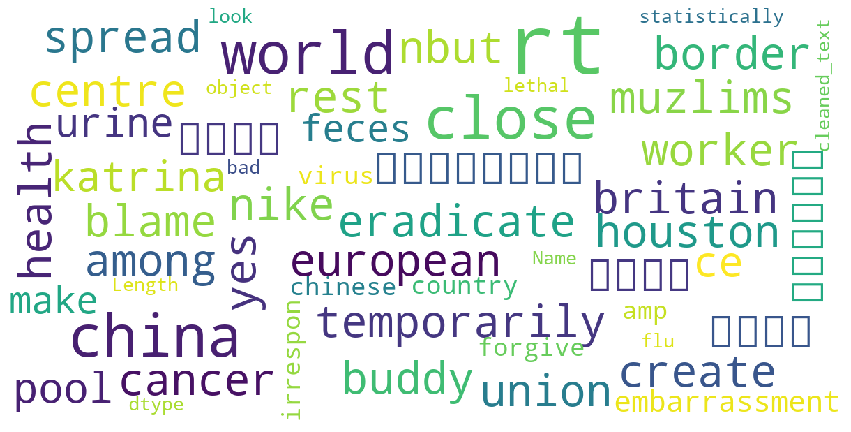

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['cleaned_text'])

In [15]:
# the column data['hashtags'] returns a list of string(s) for each tweet. Build a list of all hashtags in the dataset.
hashtag_list = []
for i in range(0, len(data)):
    # Obtain the current list of hashtags
    curr_hashtag = data.iloc[i, :]['hashtags']
    
    # Extract and append the hashtags to 'hashtag_list':
    for j in range(0, len(curr_hashtag)):
        hashtag_list.append(curr_hashtag[j])
        
# No. of hashtags
print('No. of hashtags used in {} tweets is {}'.format(len(data), len(hashtag_list)))

df_hashtag = pd.DataFrame(
    {'hashtags': hashtag_list}
)
print(df_hashtag.head(20))
print('Shape of df_hashtag is:', df_hashtag.shape)

No. of hashtags used in 4390 tweets is 13097
               hashtags
0           coronavirus
1             covid2019
2            chinavirus
3           coronavirus
4             covid2019
5            chinavirus
6      chinacoronavirus
7   coronavirusoutbreak
8         coronavirusuk
9     coronavirusitalia
10    coronavirusespaña
11       coronavirususa
12    coronavirusupdate
13              kungflu
14                 psca
15                ppic3
16               lahore
17                 city
18               corona
19                virus
Shape of df_hashtag is: (13097, 1)


                    hashtags  counts
368             chinesevirus    2052
324               chinavirus    1176
1892              wuhanvirus    1038
369           chinesevirus19     800
481              coronavirus     578
564                  covid19     366
1869                   wuhan     336
263                    china     275
297      chinaliedpeopledied     228
593                covid2019     161
1876        wuhancoronavirus     143
522      coronavirusoutbreak     131
1095                 kungflu     123
372       chineseviruscorona      99
601                 covid_19      87
609                 covidー19      80
377        chinesewuhanvirus      79
236                 ccpvirus      75
227                      ccp      71
343      chinesebioterrorism      65
273         chinacoronavirus      64
293   chinaliedandpeopledied      64
443                   corona      62
350       chinesecoronavirus      60
398                    ckmkb      51
462           coronaoutbreak      49
1

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32954 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from c

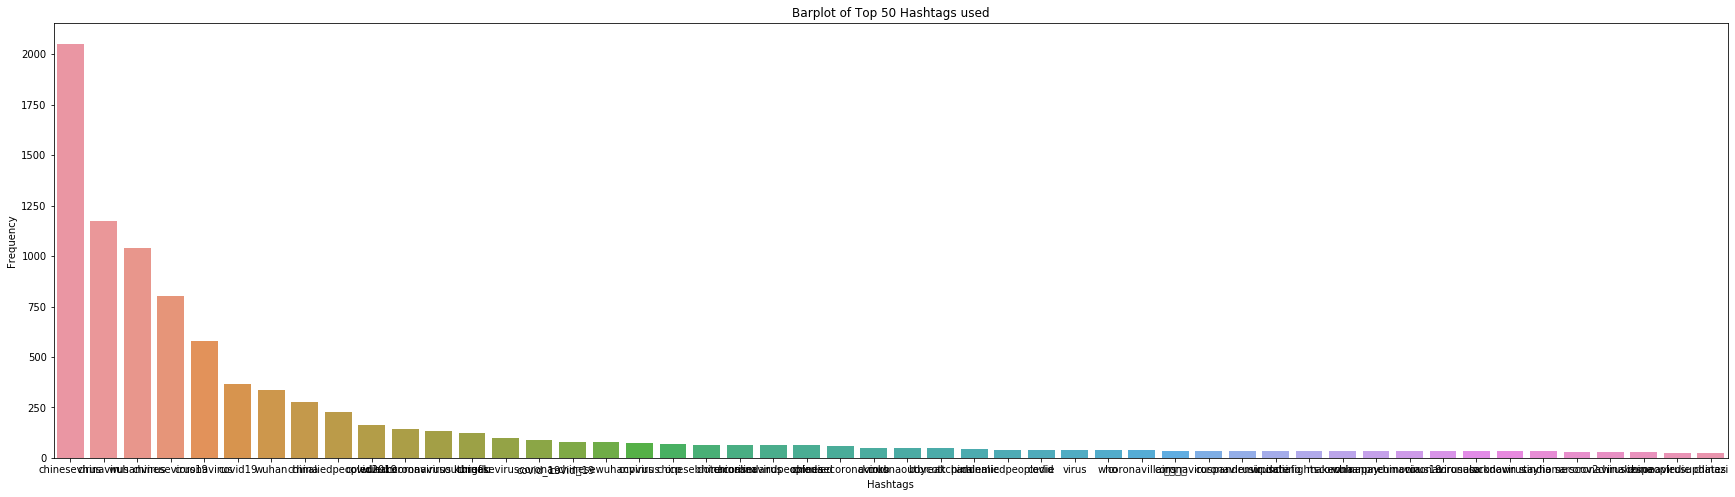

In [16]:
import seaborn as sns

# Define N to be the top number of hashtags
N = 50
top_hashtags = df_hashtag.groupby(['hashtags']).size().reset_index(name = 'counts').sort_values(by = 'counts', ascending = False).head(N)
print(top_hashtags)
# seaborn countplot on the top N hashtags
plt.figure(figsize=(30,8))
sns.set_palette('PuBuGn_d')
sns.barplot(x = 'hashtags', y = 'counts', data = top_hashtags)
plt.title('Barplot of Top ' + str(N) + ' Hashtags used')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.show()

In [17]:
def isNaN(num):
    return num != num

def get_full_name(x):
    if x is None or isNaN(x):
        return None
    else:
        return x['full_name']
data['place_full_name']=data['place'].apply(lambda x: get_full_name(x))

data[data['place_full_name'].apply(lambda x: x is not None)]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords,place_full_name
56,2020-03-03 19:58:52+00:00,1234931267944271872,1234931267944271872,Short cilp of official song of Corona virus si...,False,"[0, 203]",{'hashtags': [{'text': 'CoronavirusReachesDelh...,"{'media': [{'id': 1234931143981572099, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,short cilp official song corona virus sindhi v...,"delhi, india","a born hindu nationalist,media critique,nation...",0.000,1.000,0.00,0.0000,55,8,"Sindh, Pakistan"
109,2020-03-04 06:49:31+00:00,1235095008945917954,1235095008945917952,I will now be calling #coronavirus #kungflu,False,"[0, 44]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,call,n.a,n.a,0.000,1.000,0.00,0.0000,4,1,"Los Angeles, CA"
270,2020-03-09 03:34:44+00:00,1236857929891889153,1236857929891889152,#WuhanVirus https://t.co/j2O4JZ5477,False,"[0, 11]","{'hashtags': [{'text': 'WuhanVirus', 'indices'...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,,n.a,n.a,0.000,0.000,0.00,0.0000,0,1,"Mesa, AZ"
497,2020-03-11 18:04:18+00:00,1237801536668876800,1237801536668876800,"Visualization of the world map, and where the ...",False,"[0, 190]","{'hashtags': [{'text': 'Covid19', 'indices': [...","{'media': [{'id': 1237801437985263616, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,visualization world map virus pop last couple ...,n.a,n.a,0.000,1.000,0.00,0.0000,55,8,"Grande Prairie, Alberta"
598,2020-03-13 20:57:41+00:00,1238569947715866629,1238569947715866624,"Fuck off\nswine flu, fail \nh1n1, fail \nYour ...",False,"[0, 109]","{'hashtags': [{'text': 'WuhanVirus', 'indices'...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,fuck off\nswine flu fail fail \nyour obiden te...,n.a,n.a,0.601,0.249,0.15,-0.9134,74,12,"Houston, TX"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4183,2020-03-30 15:08:35+00:00,1244642686889385984,1244642686889385984,"करे कोई, भुगते कोई 😞 #Chinavirus 😡\n.\n#ChinaV...",False,"[0, 242]","{'hashtags': [{'text': 'Chinavirus', 'indices'...","{'media': [{'id': 1244642669642412034, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,करे कोई भुगते कोई \n.\n पूरे विश्व को परेशान क...,n.a,n.a,0.000,1.000,0.00,0.0000,53,12,"Mumbai, India"
4263,2020-03-31 15:10:18+00:00,1245005507083096065,1245005507083096064,@China_Amb_India killer China . third class Ch...,False,"[0, 102]","{'hashtags': [{'text': 'ChineseVirusCorona', '...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,killer china third class china criminal china,n.a,n.a,0.606,0.394,0.00,-0.8271,45,7,"Bengaluru South, India"
4264,2020-03-31 15:10:25+00:00,1245005536061526017,1245005536061526016,#ChinaVirus \n#ChinaLiedPeopleDied \n#Whuanvir...,False,"[0, 46]","{'hashtags': [{'text': 'ChinaVirus', 'indices'...","{'media': [{'id': 1245005532223533058, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,,n.a,n.a,0.000,0.000,0.00,0.0000,0,1,"Baripada, India"
4270,2020-03-31 15:11:39+00:00,1245005847023017984,1245005847023017984,#KungFlu #ChinaVirus #NotSorry #COVID19 #Coron...,False,"[0, 141]","{'hashtags': [{'text': 'KungFlu', 'indices': [...","{'media': [{'id': 1245005842447032320, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,,n.a,n.a,0.000,0.000,0.00,0.0000,0,1,"Middletown, NY"


In [18]:
data[data['coordinates'].apply(lambda x: x is not None and not isNaN(x))]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords,place_full_name
637,2020-03-16 21:03:34+00:00,1239658591839088640,1239658591839088640,San Francisco is locked down #coronavirus #wuh...,False,"[0, 109]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,...,san francisco lock san francisco california,n.a,n.a,0.0,1.000,0.000,0.0000,43,6,"San Francisco, CA"
2671,2020-03-27 10:04:27+00:00,1243478986476355586,1243478986476355584,#Japanese pen me #Chinese Nib lage hone se #co...,False,"[0, 144]","{'hashtags': [{'text': 'Japanese', 'indices': ...",NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,...,pen nib lage hone se failne ki kitni possibili...,n.a,n.a,0.0,1.000,0.000,0.0000,64,12,"New Delhi, India"
3678,2020-03-28 18:31:50+00:00,1243969061521768449,1243969061521768448,Lockdown Day 4 in India STAY HOME AND STAY SAF...,False,"[0, 236]","{'hashtags': [{'text': 'Chinavirus', 'indices'...",NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,...,lockdown day india stay home stay safe wish ev...,n.a,n.a,0.0,0.575,0.425,0.8779,119,19,"New Delhi, India"
